In [142]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Input
from keras.layers import Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.optimizers import SGD
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
import seaborn
import tensorflow as tf
from tensorflow.keras import regularizers

In [40]:
df_train= pd.read_csv('data_train.csv')
df_train.head()

,target,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v289,v290,v291,v292,v293,v294,v295,v296,v297,v298
0,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
2,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,1,0,0,0,0
4,0,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [41]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Columns: 299 entries, target to v298
dtypes: int64(299)
memory usage: 44.2 MB


### Split data

Solo usaremos registros con target = 0
generamos dos datasets uno de entrenamiento y otro de validación

In [42]:
df_train = df_train.loc[df_train.target ==0,:] ## solo usamos datos 0 para el entrenaiento

df_train, df_val = train_test_split(
    df_train, test_size=0.2, random_state=42, stratify=df_train['target'], shuffle=True
)

print("Train DataFrame rows: ", df_train.shape[0])
print("Val DataFrame rows: ", df_val.shape[0])

Train DataFrame rows:  6568
Val DataFrame rows:  1642


In [44]:
X_train = df_train.drop('target', axis=1)
X_val = df_val.drop('target', axis=1)
y_train = df_train['target']
y_val = df_val['target']

### Autoencoder 1

#### Train

In [45]:
np.random.seed(5)

# Modelo

n_inputs=X_train.shape[1] # dimensión de entrada
n_hidden=32 # número de neuronas para las capas ocultas y el bottleneck

# Layers
AE_input = Input(shape=(n_inputs,), name='Input-Layer')
encoder_hidden = Dense(units=n_hidden, activation='relu', name='Encoder-Hidden-Layer')(AE_input)
bottleneck = Dense(units=n_hidden, activation='relu', name='Bottleneck-Layer')(encoder_hidden)
decoder_hidden = Dense(units=n_hidden, activation='relu', name='Decoder-Hidden-Layer')(bottleneck)
AE_output = Dense(units=n_inputs, activation='sigmoid', name='Output-Layer')(decoder_hidden)

AE_model = Model(inputs=AE_input, outputs=AE_output, name='Autoencoder-Model')
AE_model.compile(optimizer='adam', loss='mse')

print(AE_model.summary())

AE_history = AE_model.fit(X_train, X_train, epochs=200, batch_size=32, verbose=1, validation_data=(X_val, X_val))

Model: "Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (InputLayer)    [(None, 298)]             0         
                                                                 
 Encoder-Hidden-Layer (Dens  (None, 32)                9568      
 e)                                                              
                                                                 
 Bottleneck-Layer (Dense)    (None, 32)                1056      
                                                                 
 Decoder-Hidden-Layer (Dens  (None, 32)                1056      
 e)                                                              
                                                                 
 Output-Layer (Dense)        (None, 298)               9834      
                                                                 
Total params: 21514 (84.04 KB)
Trainable params: 

#### Test

In [46]:
from utils import *

In [47]:
df_test = pd.read_csv('data_test.csv')
df_test.head()

,target,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v289,v290,v291,v292,v293,v294,v295,v296,v297,v298
0,0,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,1,1,1,0,1,1,1,...,1,0,0,0,0,0,0,0,0,0


In [48]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Columns: 299 entries, target to v298
dtypes: int64(299)
memory usage: 11.0 MB


In [49]:
X_test = df_test.drop('target', axis=1)
y_test = df_test['target']

In [50]:
scaler = MinMaxScaler()

X_pred = AE_model.predict(X_test)
ecm = np.mean(np.power(X_test - X_pred, 2), axis=1)
df_test['ECM'] = ecm
df_test['pred_proba-AE1'] = scaler.fit_transform(df_test[['ECM']])
df_test['pred-AE1'] = (df_test['pred_proba-AE1'] > 0.5).astype(int)
df_test['pred_proba-AE1'].describe()

152/152 [==============================] - 0s 2ms/step


count    4843.000000
mean        0.161536
std         0.127845
min         0.000000
25%         0.064640
50%         0.129863
75%         0.226996
max         1.000000
Name: pred_proba-AE1, dtype: float64

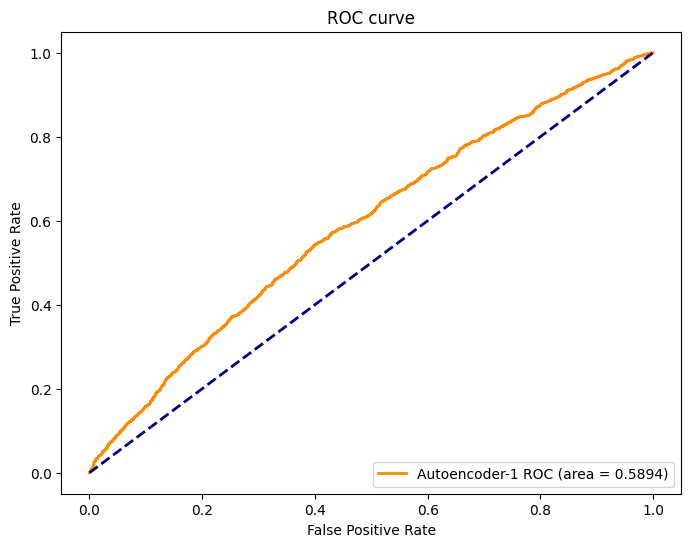

In [51]:
plot_roc_curve(df_test['pred_proba-AE1'], df_test['target'],  "Autoencoder-1")

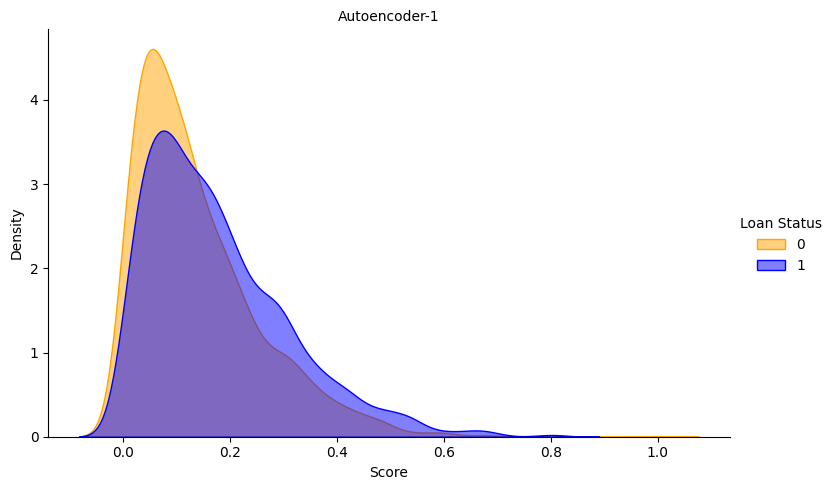

In [52]:
plot_density(df_test['pred_proba-AE1'], df_test['target'],  "Autoencoder-1")

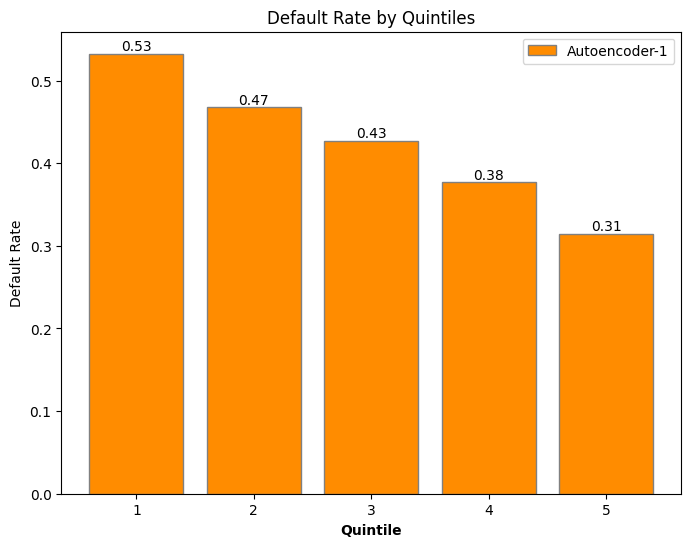

In [53]:
default_rate_by_quintile(df_test['pred_proba-AE1'], df_test['target'],  "Autoencoder-1")

In [54]:
metrics_df = calculate_metrics(df_test['pred_proba-AE1'],df_test['pred-AE1'],df_test['target'])
metrics_df

,Metric,Score
0,Average Precision Score,0.649634
1,Recall,0.027240
2,F1 Score,0.052650
3,AUC,0.589355
4,Brier Score,0.414054


----------------------------------------

#### Autoencoder 2

In [123]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [143]:
np.random.seed(5)

# Modelo

n_inputs = X_train.shape[1]  # dimensión de entrada

# Layers
AE_input = Input(shape=(n_inputs,), name='Input-Layer')

# Encoder con Batch Normalization y Dropout
encoder_hidden_1 = Dense(units=128, activation='relu', name='Encoder-Hidden-Layer-1')(AE_input)
encoder_hidden_1 = BatchNormalization()(encoder_hidden_1)
encoder_hidden_1 = Dropout(0.1)(encoder_hidden_1)
encoder_hidden_2 = Dense(units=64, activation='relu', name='Encoder-Hidden-Layer-2')(encoder_hidden_1)
encoder_hidden_2 = BatchNormalization()(encoder_hidden_2)
encoder_hidden_2 = Dropout(0.2)(encoder_hidden_2)

# Bottleneck con regularización L1
bottleneck = Dense(units=32, activation='relu', activity_regularizer=regularizers.L1(0.01), name='Bottleneck-Layer')(encoder_hidden_2)

# Decoder con Batch Normalization y Dropout
decoder_hidden_1 = Dense(units=64, activation='relu', name='Decoder-Hidden-Layer-1')(bottleneck)
decoder_hidden_1 = BatchNormalization()(decoder_hidden_1)
decoder_hidden_1 = Dropout(0.2)(decoder_hidden_1)
decoder_hidden_2 = Dense(units=128, activation='relu', name='Decoder-Hidden-Layer-2')(decoder_hidden_1)
decoder_hidden_2 = BatchNormalization()(decoder_hidden_2)
decoder_hidden_2 = Dropout(0.1)(decoder_hidden_2)

# Output Layer
AE_output = Dense(units=n_inputs, activation='sigmoid', name='Output-Layer')(decoder_hidden_2)

# Compilar el modelo
AE_model2 = Model(inputs=AE_input, outputs=AE_output, name='Autoencoder-Model-3')
AE_model2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

print(AE_model2.summary())

# Entrenar el modelo
AE_history = AE_model2.fit(X_train, X_train, epochs=100, batch_size=64, verbose=1, validation_data=(X_val, X_val))

Model: "Autoencoder-Model-3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (InputLayer)    [(None, 298)]             0         
                                                                 
 Encoder-Hidden-Layer-1 (De  (None, 128)               38272     
 nse)                                                            
                                                                 
 batch_normalization_12 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 Encoder-Hidden-Layer-2 (De  (None, 64)                8256      
 nse)                                                            
                                               

In [144]:
scaler = MinMaxScaler()

X_pred = AE_model2.predict(X_test)
ecm = np.mean(np.power(X_test - X_pred, 2), axis=1)
df_test['ECM-2'] = ecm
df_test['pred_proba-AE2'] = scaler.fit_transform(df_test[['ECM-2']])
df_test['pred_proba-AE2'] = np.clip(df_test['pred_proba-AE2'], 0, 1)
df_test['pred-AE2'] = (df_test['pred_proba-AE2'] > 0.5).astype(int)
df_test['pred_proba-AE2'].describe()

152/152 [==============================] - 0s 2ms/step


count    4843.000000
mean        0.226847
std         0.139516
min         0.000000
25%         0.123625
50%         0.199562
75%         0.300070
max         1.000000
Name: pred_proba-AE2, dtype: float64

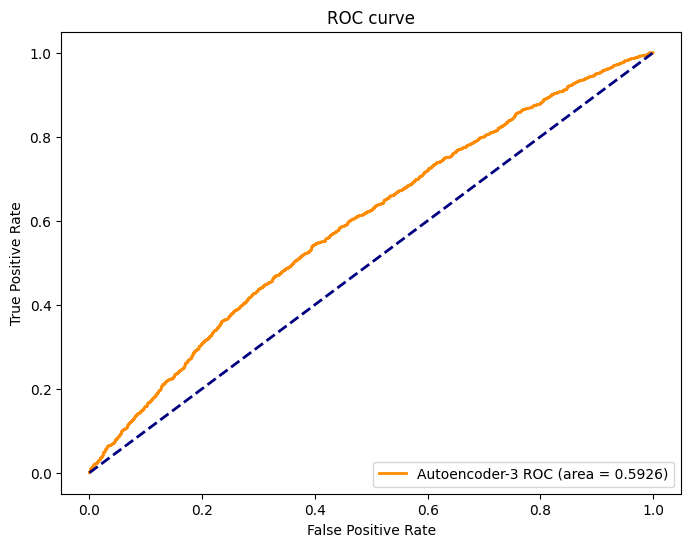

In [153]:
plot_roc_curve(df_test['pred_proba-AE3'], df_test['target'],  "Autoencoder-3")

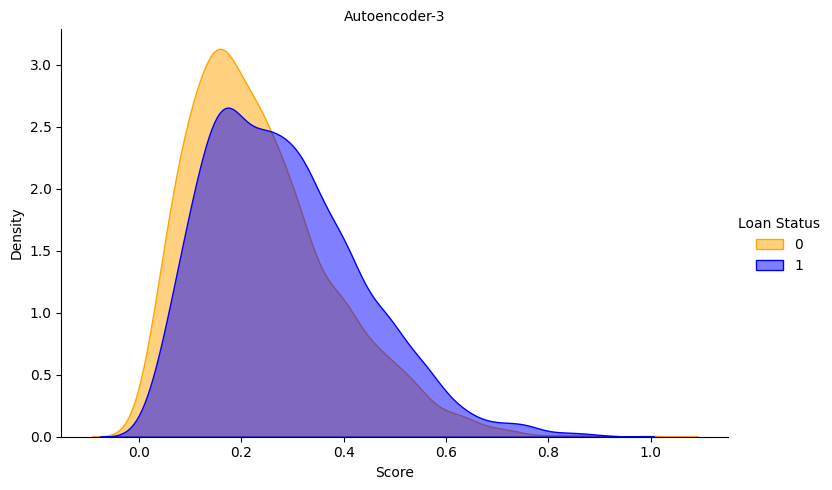

In [152]:
plot_density(df_test['pred_proba-AE3'], df_test['target'],  "Autoencoder-3")

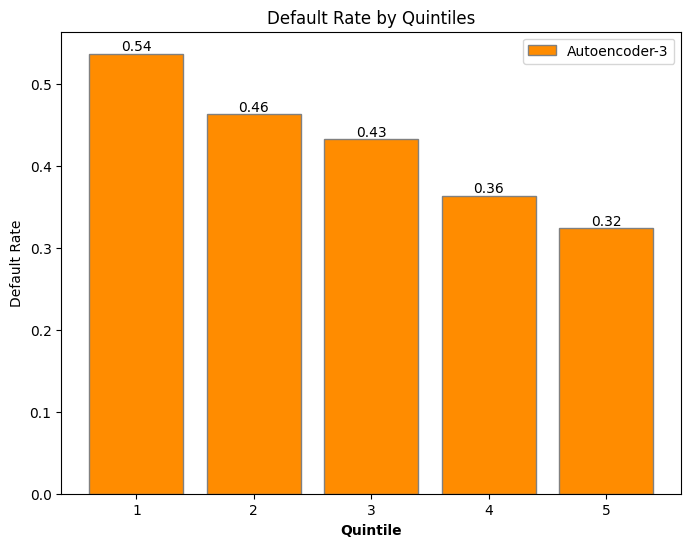

In [151]:
default_rate_by_quintile(df_test['pred_proba-AE3'], df_test['target'],  "Autoencoder-3")

In [150]:
metrics_df = calculate_metrics(df_test['pred_proba-AE3'],df_test['pred-AE3'],df_test['target'])
metrics_df

,Metric,Score
0,Average Precision Score,0.648622
1,Recall,0.091756
2,F1 Score,0.162025
3,AUC,0.592638
4,Brier Score,0.340480


#### Autoencoder 3 optuna